In [333]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

from astropy.table import Table
# How is the table formatted?
#data = Table.read('./Blackhawk/results/test/secondary_lightcurve.tex')


Read in and process dataset for photon flux.

In [328]:
# Each column is the emission rate /GeV/s/cm^3
primary = pd.read_csv('./Blackhawk/results/test/photon_primary_spectrum.txt', sep='   ', skiprows=1, dtype=float)
secondary = pd.read_csv('./Blackhawk/results/test/photon_secondary_spectrum.txt', sep='   ', skiprows=1, dtype=float)

# Cool, time indices are same everywhere
#print( np.where(primary.index != secondary.index) )
# Energy is not!
#print( np.where(primary.columns == secondary.columns) )

# Set indices correctly
primary = primary.set_index('time/energy')
secondary = secondary.set_index('time/energy')

# Remove whitespace
primary.columns = primary.columns.str.replace(' ','')
secondary.columns = secondary.columns.str.replace(' ','')

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



Create plot for the total energy-integrated photon flux for the LAT and GBM bands.

In [293]:
LAT_energy = (20*1e-3, 300) # 20 MeV, 300 GeV
GBM_energy = (200*1e-6, 40*1e-3) # 200 keV, 40 MeV (NaI only)

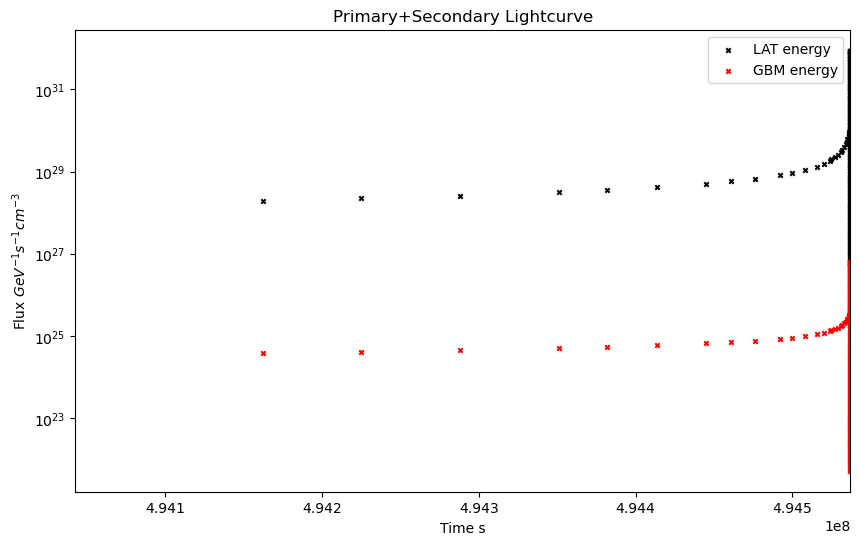

In [356]:
fig, ax = plt.subplots()

# Generic lightcurves
p_lightcurve = primary.sum(axis=1).reset_index()
s_lightcurve = secondary.sum(axis=1).reset_index()

#ax.line(p_lightcurve['time/energy'], p_lightcurve[0], s=10)
#ax.scatter(s_lightcurve['time/energy'], s_lightcurve[0], marker='x',s=10, color='black', label='LAT')

# Generate lightcurves for specific LAT/GBM energy ranges

# Primary spectrum
primary_energies = np.array(primary.columns).astype(float)
LAT_primary_energies = primary.columns[np.where((primary_energies > LAT_energy[0]) & (primary_energies < LAT_energy[1]))]
GBM_primary_energies = primary.columns[np.where((primary_energies > GBM_energy[0]) & (primary_energies < GBM_energy[1]))]

# Secondary spectrum
secondary_energies = np.array(secondary.columns).astype(float)
LAT_secondary_energies = secondary.columns[np.where((secondary_energies > LAT_energy[0]) & (secondary_energies < LAT_energy[1]))]
GBM_secondary_energies = secondary.columns[np.where((secondary_energies > GBM_energy[0]) & (secondary_energies < GBM_energy[1]))]

"""
Compute SED: f*E^2
"""
# Primary lightcurves
LAT_p_lc = (primary[LAT_primary_energies] * primary[LAT_primary_energies].columns.astype(float)**2).sum(axis=1).reset_index()
GBM_p_lc = (primary[GBM_primary_energies] * primary[GBM_primary_energies].columns.astype(float)**2).sum(axis=1).reset_index()
#ax.scatter(LAT_p_lc['time/energy'], LAT_p_lc[0], marker='.', s=10, color='black', label='LAT energy')
#ax.scatter(LAT_p_lc['time/energy'], GBM_p_lc[0], marker='.', s=10, color='red', label = 'GBM energy')

# Secondary lightcurves
LAT_s_lc = (secondary[LAT_secondary_energies] * secondary[LAT_secondary_energies].columns.astype(float)**2).sum(axis=1).reset_index()
GBM_s_lc = (secondary[GBM_secondary_energies] * secondary[GBM_secondary_energies].columns.astype(float)**2).sum(axis=1).reset_index()
#ax.scatter(LAT_s_lc['time/energy'], LAT_s_lc[0], marker='x', s=10, color='black', label='LAT energy')
#ax.scatter(LAT_s_lc['time/energy'], GBM_s_lc[0], marker='x', s=10, color='red', label = 'GBM energy')

ax.scatter(LAT_s_lc['time/energy'], LAT_s_lc[0]+LAT_p_lc[0], marker='x', s=10, color='black', label='LAT energy')
ax.scatter(LAT_s_lc['time/energy'], GBM_s_lc[0]+GBM_p_lc[0], marker='x', s=10, color='red', label = 'GBM energy')

ax.set_xlim(s_lightcurve['time/energy'].max()*(1-1e-3), s_lightcurve['time/energy'].max())

ax.set_yscale('log')
#ax.set_xscale('log')

ax.legend()
ax.set_title('Primary+Secondary Lightcurve')
ax.set_ylabel(r'Flux $GeV^{-1}s^{-1}cm^{-3}$')
ax.set_xlabel('Time s')

fig.set_figwidth(10)
fig.set_figheight(6)

Plot the hardness ratio between the LAT and GBM energies.

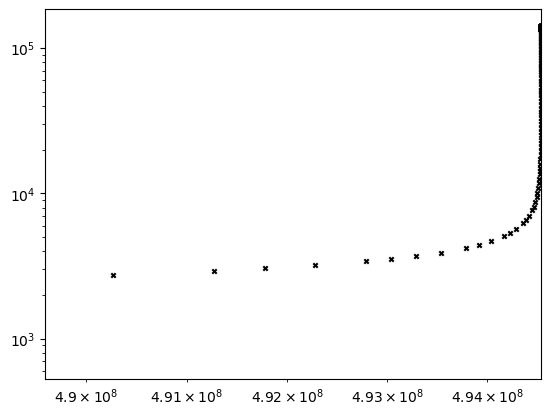

In [363]:
fig, ax = plt.subplots()

ax.scatter( LAT_s_lc['time/energy'],
    (LAT_s_lc[0] + LAT_p_lc[0])/(GBM_s_lc[0] + GBM_p_lc[0]),
    marker='x', color='black', s=10
)

ax.set_xlim(s_lightcurve['time/energy'].max()*(1 - 1e-2), s_lightcurve['time/energy'].max())

ax.set_yscale('log')
ax.set_xscale('log')